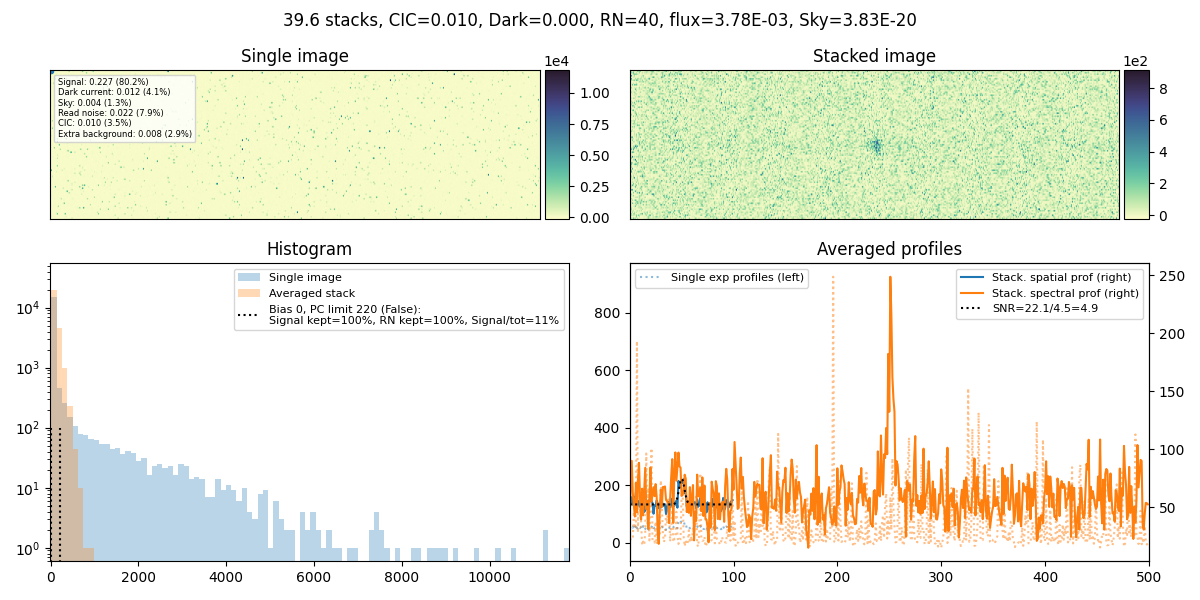

In [3]:
from Observation import *
from astropy.table import Table
import warnings
warnings.filterwarnings("ignore")

def SimulateFIREBallemCCDImage(
    conv_gain=0.53, EmGain=1500, Bias="Auto", RN=80, p_pCIC=0.0005, p_sCIC=0, Dark=5e-4, Smearing=0.7, SmearExpDecrement=50000, exposure=50, flux=1e-3, source="Slit", Rx=8, Ry=8, size=[100, 100], OSregions=[0, -1], name="Auto", spectra="-", cube="-", n_registers=604, Sky=0,save=False,stack=1,readout_time=1.5, cosmic_ray_loss=None, counting=True, QE=0.45, field="targets_F2.csv",QElambda=True,atmlambda=True,fraction_lya=0.05):
    #%%
    # ConversionGain=0.53
    # EmGain=1500
    # Bias="Auto"
    # RN=80 
    # p_pCIC=0.0005
    # p_sCIC=0
    # Dark=0.5/3600
    # Smearing=0.7
    # SmearExpDecrement=50000
    # exposure=50
    # flux=1e-3
    # source="Field"
    # Rx=4
    # Ry=4
    # name="Auto"
    # n_registers=604
    # Sky=0
    # save=False
    # stack=stack=1#int(3600*1/50)
    # readout_time=1.5
    # cosmic_ray_loss=None
    # size=[1058, 2069]
    # OSregions=[0, 1058]

    # size=[3216, 2069]
    # OSregions=[1066, 2124]
    # EmGain=1500; Bias=0; RN=80; p_pCIC=1; p_sCIC=0; Dark=1/3600; Smearing=1; SmearExpDecrement=50000; exposure=50; flux=1; Sky=4; source="Spectra m=17"; Rx=8; Ry=8;  size=[100, 100]; OSregions=[0, 120]; name="Auto"; spectra="Spectra m=17"; cube="-"; n_registers=604; save=False;readout_time=5;stack=100;QE=0.5
    from astropy.modeling.functional_models import Gaussian2D, Gaussian1D
    from scipy.sparse import dia_matrix
    from scipy.interpolate import interp1d


    OS1, OS2 = OSregions
    # ConversionGain=1
    ConversionGain = conv_gain
    Bias=0
    image = np.zeros((size[1], size[0]), dtype="float64")
    image_stack = np.zeros((size[1], size[0]), dtype="float64")

    # dark & flux
    source_im = 0 * image[:, OSregions[0] : OSregions[1]]
    source_im_wo_atm = 0 * image[:, OSregions[0] : OSregions[1]]
    lx, ly = source_im.shape
    y = np.linspace(0, lx - 1, lx)
    x = np.linspace(0, ly - 1, ly)
    x, y = np.meshgrid(x, y)

    # Source definition. For now the flux is not normalized at all, need to fix this
    # Cubes still needs to be implememted, link to detector model or putting it here?
    # if os.path.isfile(cube):
    throughput = 0.13*0.9
    atm = 0.45
    area = 7854
    dispersion = 46.6/10
    wavelength=2000
            #%%
    if source == "Flat-field":
        source_im += flux
    elif source == "Dirac":
        source_im += Gaussian2D.evaluate(x, y,  flux, ly / 2, lx / 2, Ry, Rx, 0)
    elif "Spectra" in source:
        if "mNUV=" not in source:
            # for file in glob.glob("/Users/Vincent/Downloads/FOS_spectra/FOS_spectra_for_FB/CIV/*.fits"):
            try:
                a = Table.read("Spectra/h_%sfos_spc.fits"%(source.split(" ")[1]))
                slits = None#Table.read("Targets/2022/" + field).to_pandas()
                trans = Table.read("interpolate/transmission_pix_resolution.csv")
                QE = Table.read("interpolate/QE_2022.csv")
            except FileNotFoundError: 
                a = Table.read("/Users/Vincent/Github/notebooks/Spectra/h_%sfos_spc.fits"%(source.split(" ")[-1]))
                slits = Table.read("/Users/Vincent/Github/FireBallPipe/Calibration/Targets/2022/" + field).to_pandas()
                trans = Table.read("/Users/Vincent/Github/FIREBall_IMO/Python Package/FireBallIMO-1.0/FireBallIMO/transmission_pix_resolution.csv")
                QE = Table.read("interpolate/QE_2022.csv")
            QE = interp1d(QE["wave"]*10,QE["QE_corr"])#
            trans["trans_conv"] = np.convolve(trans["col2"],np.ones(5)/5,mode="same")
            trans = trans[:-5]
            atm_trans =  interp1d([1500,2500]+list(trans["col1"]*10),[0,0] + list(trans["trans_conv"]))#

            a["photons"] = a["FLUX"]/9.93E-12   
            a["e_pix_sec"]  = a["photons"] * throughput * atm  * area /dispersion
            nsize,nsize2 = 100,500
            source_im=np.zeros((nsize,nsize2))
            source_im_wo_atm=np.zeros((nsize2,nsize))
            mask = (a["WAVELENGTH"]>1960) & (a["WAVELENGTH"]<2280)
            lmax = a["WAVELENGTH"][mask][np.argmax( a["e_pix_sec"][mask])]
            # plt.plot( a["WAVELENGTH"],a["e_pix_sec"])
            # plt.plot( a["WAVELENGTH"][mask],a["e_pix_sec"][mask])
            f = interp1d(a["WAVELENGTH"],a["e_pix_sec"])#
            profile =   Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx) /Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx).sum()
            subim = np.zeros((nsize2,nsize))
            wavelengths = np.linspace(lmax-nsize2/2/dispersion,lmax+nsize2/2/dispersion,nsize2)

            if 1==0:
                # source_im=np.zeros((100,100))
                # # plt.plot(a["WAVELENGTH"][mask],a["e_pix_exp"][mask])
                # profile =   Gaussian1D.evaluate(np.arange(100),  1,  50, Rx) /Gaussian1D.evaluate(np.arange(100),  1,  50, Rx).sum()
                # i = np.argmin(abs(a["WAVELENGTH"]-1960))
                # source_im[:,:] +=   profile
                # source_im = source_im.T*a["e_pix_sec"][i:i+100]
                
                
                fig,(ax0,ax1,ax2) = plt.subplots(3,1)
                ax0.fill_between(wavelengths, profile.max()*f(wavelengths),profile.max()* f(wavelengths) * atm_trans(wavelengths),label="Atmosphere impact",alpha=0.3)
                ax0.fill_between(wavelengths, profile.max()*f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths),profile.max()* f(wavelengths) * atm_trans(wavelengths),label="QE impact",alpha=0.3)
                ax1.plot(wavelengths,f(wavelengths)/f(wavelengths).ptp(),label="Spectra")
                ax1.plot(wavelengths, f(wavelengths)* atm_trans(wavelengths)/(f(wavelengths)* atm_trans(wavelengths)).ptp(),label="Spectra * Atm")
                ax1.plot(wavelengths, f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths)/( f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths)).ptp(),label="Spectra * Atm * QE")
                ax2.plot(wavelengths,atm_trans(wavelengths) ,label="Atmosphere")
                ax2.plot(wavelengths,QE(wavelengths) ,label="QE")
                ax0.legend()
                ax1.legend()
                ax2.legend()
                ax0.set_ylabel("e/pix/sec")
                ax1.set_ylabel("Mornalized prof")
                ax2.set_ylabel("%")
                ax2.set_xlabel("wavelength")
                ax0.set_title(source.split(" ")[-1])
                fig.savefig("/Users/Vincent/Github/notebooks/Spectra/h_%sfos_spc.png"%(source.split(" ")[-1]))
                plt.show()
            QE = QE(wavelengths) if QElambda else QE(lmax) 
            atm_trans = atm_trans(wavelengths) if atmlambda else atm_trans(lmax) 
            source_im[:,:] +=  (subim+profile).T*f(wavelengths) * atm_trans * QE
            # source_im_wo_atm[:,:] +=  (subim+profile).T*f(wavelengths) #* atm_trans(wavelengths)
        else:
            #%%
            mag=float(source.split("mNUV=")[-1])
            factor_lya = fraction_lya
            flux = 10**(-(mag-20.08)/2.5)*2.06*1E-16/((6.62E-34*300000000/(wavelength*0.0000000001)/0.0000001))
            elec_pix = flux * throughput * atm * QE * area /dispersion# should not be multiplied by exposure time here
            with_line = elec_pix*(1-factor_lya) + factor_lya * (3700/1)*elec_pix* Gaussian1D.evaluate(np.arange(size[0]),  1,  size[0]/2, Ry)/ Gaussian1D.evaluate(np.arange(size[0]),  1,  size[0]/2, Ry).sum()
            # source_im[50:55,:] += elec_pix #Gaussian2D.evaluate(x, y, flux, ly / 2, lx / 2, 100 * Ry, Rx, 0)
            profile =  np.outer(with_line,Gaussian1D.evaluate(np.arange(size[1]),  1,  50, Rx) /Gaussian1D.evaluate(np.arange(size[1]),  1,  50, Rx).sum())
            source_im = source_im.T
            source_im[:,:] += profile
            source_im = source_im.T

            # a = Table(data=([np.linspace(1500,2500,nsize2),np.zeros(nsize2)]),names=("WAVELENGTH","e_pix_sec"))
            # a["e_pix_sec"] = elec_pix*(1-factor_lya) + factor_lya * (3700/1)*elec_pix* Gaussian1D.evaluate(a["WAVELENGTH"],  1,  line["wave"], 8) 
            # f = interp1d(a["WAVELENGTH"],a["e_pix_sec"])
            # profile =   Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx) /Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx).sum()
            # subim = np.zeros((nsize2,nsize))
            # wavelengths = np.linspace(2060-yi/dispersion,2060+(1000-yi)/dispersion,nsize2)
            # source_im[int(xi-nsize/2):int(xi+nsize/2), OSregions[0] : OSregions[1]] +=  (subim+profile).T*f(wavelengths) * atm_trans(wavelengths) * QE(wavelengths)
            # source_im_wo_atm[int(xi-nsize/2):int(xi+nsize/2), OSregions[0] : OSregions[1]] +=  (subim+profile).T*f(wavelengths) #* atm_trans(wavelengths)

#%%
            # print(exposure*profile.max(), exposure*profile.sum())
    elif source == "Slit":
        ConvolveSlit2D_PSF_75muWidth = lambda xy, amp, L, xo, yo, sigmax2, sigmay2: ConvolveSlit2D_PSF(xy, amp, 2.5, L, xo, yo, sigmax2, sigmay2)
        source_im += ConvolveSlit2D_PSF_75muWidth((x, y), flux , 9, ly / 2, lx / 2, Rx, Ry).reshape(lx, ly)
    elif source == "Fibre":
        fibre = convolvePSF(radius_hole=10, fwhmsPSF=[2.353 * Rx, 2.353 * Ry], unit=1, size=(201, 201), Plot=False)  # [:,OSregions[0]:OSregions[1]]
        source_im = addAtPos(source_im, fibre, (int(lx / 2), int(ly / 2)))
 
    elif source[:5] == "Field":
       #%%
        ConvolveSlit2D_PSF_75muWidth = lambda xy, amp, L, xo, yo, sigmax2, sigmay2: ConvolveSlit2D_PSF(xy, amp, 2.5, L, xo, yo, sigmax2, sigmay2)
        ws = [2025, 2062, 2139]
        file = '/Users/Vincent/Github/fireball2-etc/notebooks/10pc/cube_204nm_guidance0.5arcsec_slit100um_total_fc_rb_detected.fits'#%(pc,wave,slit)
        gal=fits.open(file)[0].data * 0.7 #cf athmosphere was computed at 45km

        slits = Table.read("/Users/Vincent/Github/FireBallPipe/Calibration/Targets/2022/" + field).to_pandas()
        trans = Table.read("/Users/Vincent/Github/FIREBall_IMO/Python Package/FireBallIMO-1.0/FireBallIMO/transmission_pix_resolution.csv")
        QE = Table.read("interpolate/QE_2022.csv")
        QE = interp1d(QE["wave"]*10,QE["QE_corr"])#
        trans["trans_conv"] = np.convolve(trans["col2"],np.ones(5)/5,mode="same")
        trans = trans[:-5]
        atm_trans =  interp1d([1500,2500]+list(trans["col1"]*10),[0,0] + list(trans["trans_conv"]))#
        # plt.plot( trans["col1"], trans["trans_conv"])
        
        #passer en pandas
        #couper ce qui sort du detecteur
        #puis tranformer direct xmm y_lin en detecteur sans prendre en compte le redshift
        # if "yline_mm" not in slits.columns:
        #     slits["yline_mm"] = slits["y_mm"]
        # print(len(slits))
        try:
            slits.loc[ ~np.isfinite(slits["NUV_ned"]), 'NUV_ned'] = slits.loc[ ~np.isfinite(slits["NUV_ned"])]["FLUX_g"]+2#29.9
        except KeyError:
            slits.loc[ ~np.isfinite(slits["NUV_ned"]), 'NUV_ned']  = 29.9
        slits["yline_mm"] = 0
        slits["em_line"] = 0
        slits["wave"] = 0
        slits["X_IMAGE"] = (slits["y_mm"]+6.5) / 0.013
        slits["Y_IMAGE"] =( -slits["x_mm"]+13) / 0.013
        queries = ["Z<0.01","(Z>0.044 & Z<0.072) | (Z>0.081 & Z<0.117)","(Z>0.285 & Z<0.320) | (Z>0.331 & Z<0.375)","(Z>0.59 & Z<0.682) | (Z>0.696 & Z<0.78) "," (Z>0.926 & Z<0.98)| (Z>0.996 & Z<1.062) ","(Z>1.184 & Z<1.245) | (Z>1.263 & Z<1.338)"]
        for q,line in zip(queries,[2060,1908.7,1549.5,1215.67,1033.8,911.8]):
            if len(slits.query(q))>0:
                slits.loc[slits.eval(q), 'em_line'] =  line
                slits.loc[slits.eval(q), 'wave'] = (slits.query(q)['Z']+1)* line
                slits.loc[slits.eval(q), 'yline_mm'] =  slits.query(q)['y_mm']  + ((slits.query(q)['Z']+1)* line-2060)*dispersion*0.013
                slits.loc[slits.eval(q), 'X_IMAGE_line'] =  slits.query(q)['X_IMAGE']  + ((slits.query(q)['Z']+1)* line-2060)*dispersion
        Table.from_pandas(slits).write("/Users/Vincent/Github/FireBallPipe/Calibration/Targets/2022/test/" + field,overwrite=True)        
        slits = slits.query("x_mm>-13  & x_mm<13 & y_mm>-6.55 & y_mm<6.55 & yline_mm>-6.55 & yline_mm<6.55 & X_IMAGE_line>-1000")

        xs = slits["Y_IMAGE"] 
        ys = slits["X_IMAGE"]  + OSregions[0]
        # ys = slits["X_IMAGE"] - 1066 + OSregions[0]
        nsize =50
        nsize2=len(source_im[0, OSregions[0] : OSregions[1]])

        for i, line in slits.iterrows():
            yi, xi, centre,mag = np.array(line["X_IMAGE"]  + OSregions[0]) - OS1, line["Y_IMAGE"] ,line["wave"],line["NUV_ned"]
            z = line["Z"]
            factor_lya = 0.05 if z>0.001 else 0
            # if ~np.isfinite(mag):
            #     mag = 26 
            wavelength=2000
            flux = 10**(-(mag-20.08)/2.5)*2.06*1E-16/((6.62E-34*300000000/(wavelength*0.0000000001)/0.0000001))
            elec_pix = flux * throughput * atm * area /dispersion# should not be multiplied by exposure time here
            if "MAIN_ID" in slits.columns:
                if line["MAIN_ID"].replace(" ", "") in ["7C1821+6419","87GB004432.0+030343","PG1538+47"]:
                    # if line["spectra"]!="None":
                    a = Table.read("/Users/Vincent/Github/FireBallPipe/Calibration/Targets/2022/h_%sfos_spc.fits"%(line["MAIN_ID"].replace(" ", "")))
                    a["photons"] = a["FLUX"]/9.93E-12   
                    a["e_pix_sec"]  = a["photons"]  * throughput * atm * area /dispersion
                    f = interp1d(a["WAVELENGTH"],a["e_pix_sec"])#
                else:
                    a = Table(data=([np.linspace(1500,2500,nsize2),np.zeros(nsize2)]),names=("WAVELENGTH","e_pix_sec"))
                    a["e_pix_sec"] = elec_pix*(1-factor_lya) + factor_lya * (3700/1)*elec_pix* Gaussian1D.evaluate(a["WAVELENGTH"],  1,  line["wave"], 8) 
                    f = interp1d(a["WAVELENGTH"],a["e_pix_sec"])
                    # print(xi,line["X_IMAGE_line"])
            else:
                a = Table(data=([np.linspace(1500,2500,nsize2),np.zeros(nsize2)]),names=("WAVELENGTH","e_pix_sec"))
                a["e_pix_sec"] = elec_pix*(1-factor_lya) + factor_lya * (3700/1)*elec_pix* Gaussian1D.evaluate(a["WAVELENGTH"],  1,  line["wave"], 8) 
                f = interp1d(a["WAVELENGTH"],a["e_pix_sec"])
                print(xi,line["X_IMAGE_line"])
            
            profile =   Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx) /Gaussian1D.evaluate(np.arange(nsize),  1,  nsize/2, Rx).sum()
            subim = np.zeros((nsize2,nsize))
            wavelengths = np.linspace(2060-yi/dispersion,2060+(1000-yi)/dispersion,nsize2)
            source_im[int(xi-nsize/2):int(xi+nsize/2), OSregions[0] : OSregions[1]] +=  (subim+profile).T*f(wavelengths) * atm_trans(wavelengths) * QE(wavelengths)
            source_im_wo_atm[int(xi-nsize/2):int(xi+nsize/2), OSregions[0] : OSregions[1]] +=  (subim+profile).T*f(wavelengths) #* atm_trans(wavelengths)
            # source_im_wo_atm[-int(xi+nsize/2):-int(xi-nsize/2), OSregions[0] : OSregions[1]] +=  (subim+profile).T*f(wavelengths) #* atm_trans(wavelengths)
            if ~np.isfinite(f(wavelengths).max()):
                sys.exit()
            # source_im=source_im.T
            if "spectra" in slits.columns:
                if line["spectra"]!="None":
                    fig,(ax0,ax1,ax2) = plt.subplots(3,1)
                    ax0.fill_between(wavelengths, profile.max()*f(wavelengths),profile.max()* f(wavelengths) * atm_trans(wavelengths),label="Atmosphere impact",alpha=0.3)
                    ax0.fill_between(wavelengths, profile.max()*f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths),profile.max()* f(wavelengths) * atm_trans(wavelengths),label="QE impact",alpha=0.3)
                    ax1.plot(wavelengths, f(wavelengths)/f(wavelengths).ptp(),label="Spectra")
                    ax1.plot(wavelengths, f(wavelengths)* atm_trans(wavelengths)/(f(wavelengths)* atm_trans(wavelengths)).ptp(),label="Spectra * Atm")
                    ax1.plot(wavelengths, f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths)/( f(wavelengths)* atm_trans(wavelengths)*QE(wavelengths)).ptp(),label="Spectra * Atm * QE")
                    ax2.plot(wavelengths,atm_trans(wavelengths) ,label="Atmosphere")
                    ax2.plot(wavelengths,QE(wavelengths) ,label="QE")
                    ax0.legend()
                    ax1.legend()
                    ax2.legend()
                    ax0.set_ylabel("e/pix/sec")
                    ax1.set_ylabel("Mornalized prof")
                    ax2.set_ylabel("%")
                    ax2.set_xlabel("wavelength")
                    ax0.set_title(line["spectra"])
                    plt.show()

                    
                    #%%
        if 1==0:
                if 1==1:
                    wavelength=2000
                    flux = 10**(-(mag-20.08)/2.5)*2.06*1E-16/((6.62E-34*300000000/(wavelength*0.0000000001)/0.0000001))
                    elec_pix = flux * throughput * atm * QE * area /dispersion# should not be multiplied by exposure time here
                    # source_im[50:55,:] += elec_pix #Gaussian2D.evaluate(x, y, flux, ly / 2, lx / 2, 100 * Ry, Rx, 0)
                    n = 300
                    gal = np.zeros((n,n))
                    cont = Gaussian1D.evaluate(np.arange(n),  1,  int(n/2), Rx) 
                    self.Nominal_cont = cont/cont.sum()
                    profile_cont =  (1-factor_lya) * elec_pix * self.Nominal_cont
                    line = Gaussian2D.evaluate(np.meshgrid(np.arange(n),np.arange(n))[0],np.meshgrid(np.arange(n),np.arange(n))[1],  1,  int(n/2),int(n/2), Rx, 2*Ry,0) 
                    line /= line.sum()
                    profile_line =  factor_lya * (3700/1)*elec_pix* line * cont.sum()
                    gal[:,:] += profile_cont+profile_line
                    j = np.argmin(abs(centre-trans["col1"]))
                    gal_absorbed = gal.T*trans["trans_conv"][j-int(n/2):j+int(n/2)]
                    source_im = addAtPos(source_im, 1*gal_absorbed, [int(xi), int(yi)])
                    # imshow(gal.T)
                    # source_im = addAtPos(source_im, 1*profile_line, [int(xi), int(yi)])
                else:
                    #verboseprint(xi, yi)
                    i = np.argmin(abs(centre-trans["col1"]))
                    # print(i)
                    gal2 = gal*trans["trans_conv"][i-50:i+50]
                    source_im = addAtPos(source_im, 1*gal2, [int(xi), int(yi)])

    else:

        pc = int(float(source.split('=')[1].split('%')[0]))
        wave = int(float(source.split('=')[3]))
        slit = int(float(source.split('=')[2].split('mu')[0]))
        file = '%spc/cube_%snm_guidance0.5arcsec_slit%sum_total_fc_rb_detected.fits'%(pc,wave,slit)
        fitsim = fits.open(file)[0].data * 0.7 #cf athmosphere was computed at 45km
        source_im[:fitsim.shape[0],:fitsim.shape[1]]+=fitsim

        
    source_im = (Dark + source_im + Sky) * int(exposure)
    source_im_wo_atm = (Dark + source_im_wo_atm + Sky) * int(exposure)
    y_pix=1000
    # print(len(source_im),source_im.shape)
    if readout_time > 10:
        cube = np.array([(readout_time/exposure/y_pix)*np.vstack((np.zeros((i,len(source_im))),source_im[::-1,:][:-i,:]))[::-1,:] for i in np.arange(1,len(source_im))],dtype=float)
        source_im = source_im+np.sum(cube,axis=0)
    if cosmic_ray_loss is None:
        cosmic_ray_loss = np.minimum(0.005*(exposure+readout_time/2),1)#+readout_time/2
    stack = np.max([int(stack * (1-cosmic_ray_loss)),1])
    cube_stack = -np.ones((int(stack),size[1], size[0]), dtype="int32")

    # print(cosmic_ray_loss)
    n_smearing=6
    # image[:, OSregions[0] : OSregions[1]] += source_im
    # print(image[:, OSregions[0] : OSregions[1]].shape,source_im.shape)
    image[:, OSregions[0] : OSregions[1]] += np.random.gamma( np.random.poisson(source_im) + np.array(np.random.rand(size[1], OSregions[1]-OSregions[0])<p_pCIC,dtype=int) , EmGain)
    # take into acount CR losses
    #18%
    # image_stack[:, OSregions[0] : OSregions[1]] = np.nanmean([np.where(np.random.rand(size[1], OSregions[1]-OSregions[0]) < cosmic_ray_loss/n_smearing,np.nan,1) * (np.random.gamma(np.random.poisson(source_im)  + np.array(np.random.rand(size[1], OSregions[1]-OSregions[0])<p_pCIC,dtype=int) , EmGain)) for i in range(int(stack))],axis=0)
    image_stack[:, OSregions[0] : OSregions[1]] = np.mean([(np.random.gamma(np.random.poisson(source_im)  + np.array(np.random.rand(size[1], OSregions[1]-OSregions[0])<p_pCIC,dtype=int) , EmGain)) for i in range(int(stack))],axis=0)
    
    # a = (np.where(np.random.rand(int(stack), size[1],OSregions[1]-OSregions[0]) < cosmic_ray_loss/n_smearing,np.nan,1) * np.array([ (np.random.gamma(np.random.poisson(source_im)  + np.array(np.random.rand( OSregions[1]-OSregions[0],size[1]).T<p_pCIC,dtype=int) , EmGain))  for i in range(int(stack))]))
    # Addition of the phyical image on the 2 overscan regions
#     image += source_im2
    image +=  np.random.gamma( np.array(np.random.rand(size[1], size[0])<p_sCIC,dtype=int) , np.random.randint(1, n_registers, size=image.shape))
    #30%
    image_stack += np.random.gamma( np.array(np.random.rand(size[1], size[0])<int(stack)*p_sCIC,dtype=int) , np.random.randint(1, n_registers, size=image.shape))
    if counting:
        a = np.array([ (np.random.gamma(np.random.poisson(source_im)  + np.array(np.random.rand( OSregions[1]-OSregions[0],size[1]).T<p_pCIC,dtype="int32") , EmGain))  for i in range(int(stack))])
        cube_stack[:,:, OSregions[0] : OSregions[1]] = a
        cube_stack += np.random.gamma( np.array(np.random.rand(int(stack),size[1], size[0])<int(stack)*p_sCIC,dtype=int) , np.random.randint(1, n_registers, size=image.shape)).astype("int32")

    #         # addition of pCIC (stil need to add sCIC before EM registers)
    #         prob_pCIC = np.random.rand(size[1], size[0])  # Draw a number prob in [0,1]
    #         image[prob_pCIC < p_pCIC] += 1
    #         source_im2_stack[prob_pCIC < p_pCIC*stack] += 1

    #         # EM amp (of source + dark + pCIC)
    #         id_nnul = image != 0
    #         image[id_nnul] = np.random.gamma(image[id_nnul], EmGain)

            # Addition of sCIC inside EM registers (ie partially amplified)
    #         prob_sCIC = np.random.rand(size[1], size[0])  # Draw a number prob in [0,1]
    #         id_scic = prob_sCIC < p_sCIC  # sCIC positions
    #         # partial amplification of sCIC
    #         register = np.random.randint(1, n_registers, size=id_scic.sum())  # Draw at which stage of the EM register the electorn is created
    #         image[id_scic] += np.random.exponential(np.power(EmGain, register / n_registers))

        # semaring post EM amp (sgest noise reduction)
        #TODO must add smearing for cube!
    if Smearing > 0:
        # smearing dependant on flux
        #2%
        smearing_kernels = variable_smearing_kernels(image, Smearing, SmearExpDecrement)
        offsets = np.arange(n_smearing)
        A = dia_matrix((smearing_kernels.reshape((n_smearing, -1)), offsets), shape=(image.size, image.size))

        image = A.dot(image.ravel()).reshape(image.shape)
        image_stack = A.dot(image_stack.ravel()).reshape(image_stack.shape)

    #     if readout_time > 0:
    #         # smearing dependant on flux
    #         smearing_kernels = variable_smearing_kernels(image.T, readout_time, SmearExpDecrement)#.swapaxes(1,2)
    #         offsets = np.arange(n_smearing)
    #         A = dia_matrix((smearing_kernels.reshape((n_smearing, -1)), offsets), shape=(image.size, image.size))#.swapaxes(0,1)

    #         image = A.dot(image.ravel()).reshape(image.shape)#.T
    #         image_stack = A.dot(image_stack.ravel()).reshape(image_stack.shape)#.T
            
            
        # read noise
    #14%
    type_ = "int32"
    type_ = "float64"
    readout = np.random.normal(Bias, RN, (size[1], size[0]))
    readout_stack = np.random.normal(Bias, RN/np.sqrt(int(stack)), (size[1], size[0]))
    if counting:
        readout_cube = np.random.normal(Bias, RN, (int(stack),size[1], size[0])).astype("int32")
        # print((np.random.rand(source_im.shape[0], source_im.shape[1]) < cosmic_ray_loss).mean())
        #TOKEEP  for cosmic ray masking readout[np.random.rand(source_im.shape[0], source_im.shape[1]) < cosmic_ray_loss]=np.nan
        #print(np.max(((image + readout) * ConversionGain).round()))
    #     if np.max(((image + readout) * ConversionGain).round()) > 2 ** 15:
    imaADU_wo_RN = (image * ConversionGain).round().astype(type_)
    imaADU_RN = (readout * ConversionGain).round().astype(type_)
    imaADU = ((image + 1*readout) * ConversionGain).round().astype(type_)
    imaADU_stack = ((image_stack + 1*readout_stack) * ConversionGain).round().astype(type_)
    if counting:
        imaADU_cube = ((cube_stack + 1*readout_cube) * ConversionGain).round().astype("int32")
    else:
        imaADU_cube = imaADU_stack
    return imaADU, imaADU_stack, imaADU_cube, source_im, source_im_wo_atm#imaADU_wo_RN, imaADU_RN



%matplotlib widget
%reload_ext autoreload
from astropy.table import Table
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import inspect
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import inspect
import re
from scipy.sparse import dia_matrix
from scipy.interpolate import interpn
# plt.style.use('dark_background')
import functools
from scipy.optimize import curve_fit
# from pyds9plugin.DS9Utils import fitswrite
np.seterr(invalid='ignore')


#%% 
# from tools_etc import SimulateFIREBallemCCDImage
# from pyds9plugin.tools import SimulateFIREBallemCCDImage
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.seterr(invalid='ignore')
import matplotlib
from matplotlib.colors import LogNorm
# from pyds9plugin.DS9Utils import PlotFit1D

import math as mt
import cmocean

def mostFrequent(arr):
    n=len(arr)
    # Insert all elements in Hash.
    Hash = dict()
    for i in range(n):
        if arr[i] in Hash.keys():
            Hash[arr[i]] += 1
        else:
            Hash[arr[i]] = 1
 
    # find the max frequency
    max_count = 0
    res = -1
    for i in Hash:
        if (max_count < Hash[i]):
            res = i
            max_count = Hash[i]
         
    return res

gaus = lambda x, a, xo, sigma, offset: a ** 2 * np.exp(-np.square((x - xo) / sigma) / 2)+ offset

#TODO add fraction kept
#TODO change flux value to good one (after convolving by PSF and size of source)
# n1,n=100,500
n2,n1=100,500
class Image(widgets.HBox):
     
    def __init__(self, exposure_time=50, acquisition_time=1, Sky=4, Signal=5.57e-18, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='Spectra 0044p030',counting_mode=False,smearing=0.7,extra_background=0,PSF_RMS_mask=2.5,PSF_RMS_det = 3.5,QE=0.45,cosmic_ray_loss_per_sec=0.005,threshold=5.5,readout_sequence="S2_hdr: 0.97 ADU/e-, FW=52 KADU"):#,conv_gain=0.2,full_well=40000):
        super().__init__()
        self.output = widgets.Output()
        self.extra_background=extra_background
        self.colors= ['#E24A33','#348ABD','#988ED5','#FBC15E','#8EBA42','#FFB5B8','#777777']

        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
        if "Spectra m" in x_axis:
            Signal = float(x_axis.split("=")[-1])
            psf_source = 0.1
        else:
            psf_source = 4
        ros_number, conv_gain, full_well = np.array(re.findall(r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?', readout_sequence),dtype=float)

        self.Nominal = Observation(exposure_time=exposure_time,Sky=Sky, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,extra_background=self.extra_background,PSF_RMS_mask=PSF_RMS_mask,PSF_RMS_det=PSF_RMS_det,QE=QE,cosmic_ray_loss_per_sec=cosmic_ray_loss_per_sec)
        Sky = np.unique(self.Nominal.Sky)[0]/exposure_time
        flux = np.unique(self.Nominal.Signal_el)/exposure_time

        self.im,self.im_stack, self.cube_stack, self.im0, _ = SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+extra_background)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, Sky=Sky, source=x_axis, Rx=PSF_RMS_det, Ry=PSF_RMS_det, size=[n1, n2], OSregions=[0, max(n2,n1)], name="Auto", spectra="-", cube="-", n_registers=604, save=False,readout_time=readout_time,stack=int(self.Nominal.N_images_true),QE=QE,conv_gain=conv_gain)
        # self.im0,self.im_stack,self.im = SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+extra_background)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, Sky=Sky, source='fesc=10%, slit=100mu, w=204', Rx=5, Ry=5, size=[100, 100], OSregions=[0, 100], name="Auto", spectra="-", cube="-", n_registers=604, save=False,readout_time=readout_time,stack=int(self.Nominal.N_images_true))
        # self.im_stack=self.im_stack/self.im
        self.current_cmap = cmocean.cm.deep# current_cmap = cmocean.cm.solar# self.current_cmap = cmocean.cm.thermal
        

        self.current_cmap.set_bad(color='black')
        self.bins=np.arange(-100,4000,100)
        self.bins=np.linspace(-100,np.nanmax(self.im),100)
        
        self.mod = mostFrequent(self.cube_stack[:,:20,:].flatten())
        self.limit = self.mod+threshold*RN


        self.fig2, ((self.nax,self.nax0),(self.nax2,self.nax1))  = plt.subplots(2,2,figsize=(12,6), gridspec_kw={'height_ratios': [0.5, 1]})#Nominal.PlotNoise()

        if counting_mode:
            stacked_image = np.nansum(self.cube_stack>self.limit,axis=0)
            im0 = self.nax0.imshow(stacked_image, aspect="auto",cmap=self.current_cmap)
        else:
            im0 = self.nax0.imshow(self.im_stack, aspect="auto",cmap=self.current_cmap)

        # import matplotlib.gridspec as gridspec
        # self.fig2 =  plt.fig2ure(figsize=(12,8))
        # gs = self.fig2.add_gridspec(3, 11)
        # self.nax  = self.fig2.add_subplot(gs[:2, :5])
        # self.nax0 = self.fig2.add_subplot(gs[:2, 5:10])
        # self.nax1 = self.fig2.add_subplot(gs[2:, :5])
        # self.nax2 = self.fig2.add_subplot(gs[2:, 5:10])
        # self.nax3 = self.fig2.add_subplot(gs[:, 10])
        # self.nax3.stackplot([1,2],self.Nominal.electrons_per_pix[:2,:].T,alpha=0.7,colors=self.colors)
        im = self.nax.imshow(self.im, aspect="auto",cmap=self.current_cmap)#, norm=LogNorm())
        labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(self.Nominal,"electrons_per_pix")[self.Nominal.i,j],100*getattr(self.Nominal,"electrons_per_pix")[self.Nominal.i,j]/np.sum(getattr(self.Nominal,'electrons_per_pix')[self.Nominal.i,:])) for j,name in enumerate(self.Nominal.names)]
        self.nax.plot(0,0,".",label="\n".join(labels))
        self.nax.legend(loc="upper left",handlelength=0, handletextpad=0, fancybox=True,markerscale=0,fontsize=6)
        # self.nax.text(0,0,"\n".join(labels))
        im2=self.nax0.imshow(self.im_stack, aspect="auto",cmap=self.current_cmap)#, norm=LogNorm())
        self.nax0.get_xaxis().set_ticks([])
        self.nax0.get_yaxis().set_ticks([])
        self.nax.get_xaxis().set_ticks([])
        self.nax.get_yaxis().set_ticks([])
        self.nax.set_title('Single image')
        self.nax0.set_title('Stacked image')
        self.nax1.set_title('Averaged profiles')
        self.nax2.set_title('Histogram')
        self.l1 = self.nax1.plot(self.im[:,45:-45].mean(axis=1),':',label='Single exp profiles (left)',alpha=0.5)
        self.l2 = self.nax1.plot(self.im[40:-40,:].mean(axis=0),':',alpha=0.5)
        self.nax1bis = self.nax1.twinx()

        self.profile = np.mean(im0.get_array().data[:,45:-45],axis=1)
        if "Spectra m=" not in x_axis:
            self.nax1.lines[0].set_ydata(self.profile)
            self.nax1.lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) # spectral direction, only if not spectra
            self.l1_s = self.nax1bis.plot(self.profile,label='Stack. spatial prof (right)',c=self.l1[0].get_color())
            self.l2_s = self.nax1bis.plot(self.im_stack[40:-40,:].mean(axis=0),label='Stack. spectral prof (right)',c=self.l2[0].get_color())
        else:
            spatial_profile = self.im[:,:].mean(axis=1)
            self.nax1.lines[0].set_ydata(np.convolve(spatial_profile,3,mode="same"))
            self.profile = np.mean(im0.get_array().data[:,:],axis=1)
            self.l1_s = self.nax1bis.plot(self.profile,label='Stack. spatial prof (right)',c=self.l1[0].get_color())
            self.l2_s = self.nax1bis.plot(self.im_stack[40:-40,:].mean(axis=0),label='Stack. spectral prof (right)',c=self.l2[0].get_color())
        try:
            self.popt, self.pcov = curve_fit(gaus,np.arange(len(self.profile)),self.profile,p0=[self.profile.ptp(), 50, 5, self.profile.min()])
        except RuntimeError:
            self.popt = [0,0,0,0]

        # self.fit = PlotFit1D(x= np.arange(len(self.profile)),y=self.profile,deg="gaus", plot_=False,ax=self.nax1bis,c="k",ls=":",P0=[self.profile.ptp(), 50, 5, self.profile.min()])
        self.nax1bis.plot( np.arange(len(self.profile)),gaus( np.arange(len(self.profile)),*self.popt),":k",label="SNR=%0.1f/%0.1f=%0.1f"%(self.popt[0]**2,self.profile[:20].std(),self.popt[0]**2/self.profile[:20].std()))

        self.nax1.set_xlim((0,n1))
        self.nax1.legend(loc='upper left',fontsize=8)
        self.nax1bis.legend(loc='upper right',fontsize=8)
        _,_,self.bars1 = self.nax2.hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
        _,_,self.bars2 = self.nax2.hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')
        title = 'Signal kept=%i%%, RN kept=%i%%, Signal/tot=%i%%'%(100*self.Nominal.Photon_fraction_kept[0], 100*self.Nominal.RN_fraction_kept[0],100*(np.mean(self.im_stack[40:-40,:])-np.mean(self.im_stack[:20,:]))/np.mean(self.im_stack[40:-40,:]))
        self.nax2.plot([self.mod,self.mod],[0,100],c="k",ls=":",label="Bias %i, PC limit %i (%s):\n%s"%(self.mod,self.limit, counting_mode, title))
        self.nax2.plot([self.limit,self.limit],[0,100],c="k",ls=":")#,label="PC limit %i: %s"%(self.limit, title))

                      
        self.nax2.legend(loc='upper right',fontsize=8,)
        self.nax2.set_xlim(xmin=-10, xmax=self.bins.max())
        self.cax = make_axes_locatable(self.nax).append_axes('right', size='5%', pad=0.05)
        self.cax0 = make_axes_locatable(self.nax0).append_axes('right', size='5%', pad=0.05)
        self.cbar1 = self.fig2.colorbar(im, cax=self.cax, orientation='vertical')
        self.cbar2 = self.fig2.colorbar(im2, cax=self.cax0, orientation='vertical')
        self.cbar1.formatter.set_powerlimits((0, 0))
        self.cbar2.formatter.set_powerlimits((0, 0))
        self.fig2.canvas.toolbar_position = 'bottom'

        title = '%0.1f stacks, CIC=%0.3f, Dark=%0.3f, RN=%i, flux=%0.2E, Sky=%0.2E'%(self.Nominal.N_images_true,CIC_charge,Dard_current/3600,RN,flux,Sky)

        self.fig2.suptitle(title)

        self.fig2.tight_layout()
        style={}
        width = '400px'
        continuous_update=False

        self.reset = widgets.Button(value=False,description='↺',disabled=False,button_style='',tooltip='Reset values', layout=Layout(width="40px"))

        self.exposure_time = widgets.IntSlider( min=1, max=250,value=exposure_time, layout=Layout(width=width),description='Texp (s)',continuous_update=continuous_update,tooltip="Single frame exposure time in seconds")
        self.acquisition_time = widgets.FloatSlider( min=0.02, max=8,value=acquisition_time, layout=Layout(width=width),description='Taq (h)',continuous_update=continuous_update,tooltip="Total acquisition time in hours")
        # self.Sky = widgets.FloatLogSlider( min=1, max=7,value=10**Sky,base=10, style =style, layout=Layout(width=width),description='Sky (LU)',continuous_update=continuous_update,tooltip="Level of Sky background illumination in line units")#4

        self.Sky = widgets.FloatLogSlider( min=-19, max=-15,value=Sky,base=10, style =style, layout=Layout(width=width),description='Sky',description_tooltip="Level of Sky background illumination in ergs/cm2/s/arcsec2/Å ")#5.57e-18


        self.EM_gain = widgets.IntSlider( min=1, max=2000,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain',continuous_update=continuous_update,tooltip="EMCCD amplification gain in e-/e-")
        self.RN = widgets.IntSlider( min=0, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise',continuous_update=continuous_update,tooltip="EMCCD readout noise in electrons")
        self.CIC_charge = widgets.FloatSlider( min=0, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',continuous_update=continuous_update,tooltip="EMCCD spurious charges due to amplification in electrons")
        self.Dard_current = widgets.FloatSlider( min=0, max=5,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',continuous_update=continuous_update,tooltip="Dark current of the EMCCD in electrons per hour")
        self.readout_time = widgets.FloatSlider( min=0, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1,continuous_update=continuous_update,tooltip="Readout time of the EMCCD controller in seconds")
        self.x_axis = widgets.Dropdown(options=["Spectra 1538p477 NUV~16.6","Spectra 1821p643 NUV~14",'Spectra 0044p030 NUV~16.5',"Spectra mrk509","Spectra 2344p092","Spectra 1637p574","Spectra 1115p080","Spectra 0414m060","Spectra 0115p027","Spectra 2251p113","Spectra 2201p315","Spectra 1928p738","Spectra 1700p518",'fesc=10%, slit=100mu, w=204','fesc= 1%, slit=100mu, w=204','Spectra mNUV=7','Spectra mNUV=10','Spectra mNUV=11','Spectra mNUV=12','Spectra mNUV=13','Spectra mNUV=14','Spectra mNUV=15','Spectra mNUV=15','Spectra mNUV=16','Spectra mNUV=17','Spectra mNUV=17.5','Spectra mNUV=18','Spectra mNUV=19','Spectra mNUV=20','Spectra mNUV=22','Spectra mNUV=24','fesc=10%, slit= 50mu, w=204','fesc= 1%, slit= 50mu, w=204','fesc=10%, slit=300mu, w=204','fesc= 1%, slit=300mu, w=204','fesc=10%, slit=100mu, w=200','fesc=10%, slit= 50mu, w=200','fesc=10%, slit=300mu, w=200','fesc=10%, slit=100mu, w=208','fesc=10%, slit= 50mu, w=208','fesc=10%, slit=300mu, w=208'], layout=Layout(width='350px'),description='Entry',value=x_axis)
        #PN K 1-16 13.5
        # PG0044+030 16.5
        # IRAS 18216+6418  14
        self.readout_sequence = widgets.Dropdown(options=["S2: 0.053 ADU/e-, FW=5.6 KADU","S2_hdr: 0.97 ADU/e-, FW=52 KADU","1: 0.02 ADU/e-, FW=2.1 KADU","1': 0.4 ADU/e-, FW=40 KADU","2: 0.04 ADU/e-, FW=4.7 KADU","2018: 0.5 ADU/e-, FW=56 KADU","2022: 0.2 ADU/e-, FW=22 KADU","2023_noOS: 0.04 ADU/e-, FW=39 KADU"], layout=Layout(width='350px'),description='RO seq',value=readout_sequence,continuous_update=False)
        #Dropdown  ,  Combobox
        # self.readout_sequence = widgets.Combobox(options=["1: 42 ADU/e-, FW=2.1 KADU","1': 2.3 e-/ADU, FW=40 KADU","2: 22 e-/ADU, FW=4.7 KADU","2018: 1.8 e-/ADU, FW=56 KADU","2022: 4.5 e-/ADU, FW=22 KADU"], layout=Layout(width='350px'),description='RO seq',value="1: 42 e-/ADU, FW=2.1 KADU",continuous_update=False)
        self.units = widgets.Dropdown(options=["ADU/frame","amplified e-/frame","e-/frame","photons/frame","e-/hour","amplified e-/hour","photons/hour"], layout=Layout(width='350px'),description='Units',value="ADU/frame")# TODO add ergs/cm2/...
        self.fraction_lya = widgets.FloatSlider( min=0, max=0.2,value=0.05,style = style, layout=Layout(width=width),description='Lya fraction',step=0.001,readout_format='.2f',tooltip="Fraction of E(Lya)/E(NUV)")
        # self.conv_gain = widgets.FloatSlider( min=0.02, max=1,value=conv_gain, style = style, layout=Layout(width=width),description=r'Cgain',step=0.01,continuous_update=continuous_update,tooltip="Conversion gain in ADU per e-")
        # self.full_well = widgets.FloatSlider( min=2000, max=60000,value=full_well, style = style, layout=Layout(width=width),description=r'Full well',step=0.01,continuous_update=continuous_update,tooltip="Full well in ADU (max number of ADU per pixel per frame)")

        self.fwhm = widgets.FloatRangeSlider( min=0.1, max=6,value=(PSF_RMS_mask,PSF_RMS_det),style = style, layout=Layout(width=width),description='Pre/post Mask σ',step=0.1,readout_format='.1f',tooltip="Spatial/Spectral resolution in arcseconds respectively before the spectrgraph (guidance+LO+FC) and of the spectragraph. To be multiplied by 2.35 to have the FWHM.")
        self.QE = widgets.FloatSlider( min=0, max=1,value=self.Nominal.QE,style = style, layout=Layout(width=width),description='QE',step=0.01,readout_format='.2f',tooltip="EMCCD quantum efficiency in percents")
        self.extra_background = widgets.FloatSlider( min=0, max=5,value=extra_background,style = style, layout=Layout(width=width),description='Guider noise',step=0.2,readout_format='.1f',tooltip="Guider induced background level in electrons per hour")

        self.counting_mode = widgets.Checkbox(value=counting_mode,description='Counting',disabled=False,tooltip="Check this box to apply thresholding photon counting processing. The efficiency of this process is determined by the gain, read noise, smearing, flux.",layout=Layout(width="187px"))

        self.QElambda = widgets.Checkbox(value=True,description='QE(λ)',disabled=False,tooltip="Check this box to apply λ QE dependancy",layout=Layout(width="147px"))
        self.atmlambda = widgets.Checkbox(value=True,description='atm(λ)',disabled=False,tooltip="Check this box to apply λ atm transmission dependancy",layout=Layout(width="217px"))
        # smearing = widgets.FloatSlider( min=0, max=1.5,value=0.7, layout=Layout(width='500px'),description='CTE not yet',step=0.001)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')

        def reset(_):
            # for name in ["exposure_time","acquisition_time","Sky","Signal","EM_gain","RN","CIC_charge","smearing","Dard_current","readout_time","x_axis","counting_mode","smearing","extra_background","QE"]:
            #     rsetattr(self, '%s.value'%(name), locals_[name]) 
            self.readout_time.value = self.readout_time.value - 0.001
            # self.update()
            pass
        self.reset.on_click(reset)

        
        self.threshold = widgets.FloatSlider( min=-1.1, max=30.1,value=5.5, style = style, layout=Layout(width="347px"),description='Threshold',continuous_update=continuous_update,readout_format='.1f',step=0.1,tooltip="Threshold (n) used when photon counting mode: T=bias+nσ.")
        self.threshold.layout.visibility ='hidden'
        # self.counting_mode.layout.visibility = 'hidden'
        self.smearing = widgets.FloatSlider( min=0, max=2,value=smearing, layout=Layout(width=width),description='Smearing',step=0.01,continuous_update=continuous_update)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
#         self.smearing.layout.visibility = 'hidden'
    
        # wids = widgets.interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky=Sky,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
        wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky=self.Sky,acquisition_time=self.acquisition_time,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time,fwhm = self.fwhm,QE=self.QE, extra_background=self.extra_background,threshold=self.threshold,QElambda=self.QElambda,atmlambda=self.atmlambda,readout_sequence=self.readout_sequence,units=self.units,fraction_lya=self.fraction_lya)#,reset=self.reset)#,Signal=self.Signal,conv_gain=self.conv_gain, full_well=self.full_well
        # controls = VBox([HBox([self.x_axis,self.reset,self.threshold,self.counting_mode,self.QElambda,self.atmlambda]),   HBox([self.Sky,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]) , HBox([self.fwhm, self.extra_background, self.QE]) , HBox([self.readout_sequence, self.units, self.fraction_lya])] )#self.conv_gain, self.full_well
        controls = VBox([HBox([self.x_axis,self.reset,self.readout_sequence, self.units]),   HBox([self.Sky,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]) , HBox([self.fwhm, self.extra_background, self.QE]) , HBox([self.fraction_lya, self.counting_mode,self.atmlambda,self.QElambda,self.threshold,])] )#self.conv_gain, self.full_well
        #self.threshold,self.counting_mode,self.QElambda,self.atmlambda
        display(HBox([self.output,controls]))

# TODO add the conversion gain the calculus of magnitude        

    def update(self, x_axis,counting_mode,Sky,acquisition_time,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing,fwhm,QE,extra_background,threshold,QElambda,atmlambda, readout_sequence,units, fraction_lya,cosmic_ray_loss_per_sec=0.005):#,reset=0):#Signal,conv_gain,full_well,
        """Draw line in plot"""
        # from pyds9plugin.tools import SimulateFIREBallemCCDImage
        # from tools_etc import SimulateFIREBallemCCDImage



        with self.output:
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
#             title='Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E, e-/pix=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky,self.el_per_pix)
#             value = locals_[x_axis]
            if "Spectra mNUV=" in x_axis:
                Signal = float(x_axis.split("=")[-1])
                psf_source = 0.1
                self.fraction_lya.layout.visibility = 'visible'
            else: 
                Signal = 20
                psf_source = 4
                self.fraction_lya.layout.visibility = 'hidden'
            if counting_mode:
                self.threshold.layout.visibility = 'visible'
            else:
                self.threshold.layout.visibility = 'hidden'
            self.Nominal = Observation(exposure_time=exposure_time,Sky=Sky, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,extra_background=extra_background,QE=QE)
            Sky = np.unique(self.Nominal.Sky)[0]/exposure_time
            flux = np.unique(self.Nominal.Signal_el)/exposure_time
            ros_number, conv_gain, full_well = np.array(re.findall(r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?', readout_sequence),dtype=float)
            # conv_gain = 1/conv_gain
            full_well *= 1000

            self.im,self.im_stack, self.cube_stack,self.im0,_  =  SimulateFIREBallemCCDImage(EmGain=EM_gain, Bias=0, RN=RN, p_pCIC=CIC_charge, p_sCIC=0, Dark=(Dard_current+extra_background)/3600, Smearing=smearing, SmearExpDecrement=50000, exposure=exposure_time, flux=flux, Sky=Sky, source=x_axis, Rx=fwhm[-1], Ry=np.sqrt(fwhm[-1]**2 + fwhm[0]**2), size=[n1, n2], OSregions=[0, max(n2,n1)], name="Auto", spectra="-", cube="-", n_registers=604, save=False,stack=int(self.Nominal.N_images_true),readout_time=readout_time,QE=QE,QElambda=QElambda,atmlambda=atmlambda,conv_gain=conv_gain,fraction_lya=fraction_lya)
            self.im[self.im>full_well] = np.nan
            self.current_cmap.set_bad('red',1.)
            if units=="ADU/frame": #ADU/frame: ok basic
                factor=1
            elif units=="amplified e-/frame": #e-/frame: divide by conversion gain and amplification gain
                factor=1/conv_gain
            elif units=="e-/frame": #e-/frame: divide by conversion gain and amplification gain
                factor=1/conv_gain/EM_gain
            elif units=="photons/frame": #photons/frame: account for QE
                factor=1/conv_gain/EM_gain/QE
            elif units=="amplified e-/hour": #e-/hour: divide by exptime
                factor=1/conv_gain/exposure_time/3600
            elif units=="e-/hour": #e-/hour: divide by exptime
                factor=1/conv_gain/EM_gain/exposure_time/3600
            elif units=="photons/hour": #photons/hour: divide by exptime, account for QE
                factor=1/conv_gain/EM_gain/QE/exposure_time/3600

            im = self.nax.imshow(self.im*factor, aspect="auto",cmap=self.current_cmap)
            self.mod = mostFrequent(self.im_stack[:20,:].flatten())
            self.limit = self.mod+threshold*RN

            if counting_mode:
                stacked_image = np.nansum(self.cube_stack>self.limit,axis=0)
                im0 = self.nax0.imshow(stacked_image, aspect="auto",cmap=self.current_cmap)
            else:
                im0 = self.nax0.imshow(self.im_stack*factor, aspect="auto",cmap=self.current_cmap)
            self.cbar1 = self.fig2.colorbar(im, cax=self.cax, orientation='vertical')
            self.cbar2 = self.fig2.colorbar(im0, cax=self.cax0, orientation='vertical')
            self.cbar1.formatter.set_powerlimits((0, 0))
            self.cbar2.formatter.set_powerlimits((0, 0))

            labels =  ['%s: %0.3f (%0.1f%%)'%(name,getattr(self.Nominal,"electrons_per_pix")[self.Nominal.i,j],100*getattr(self.Nominal,"electrons_per_pix")[self.Nominal.i,j]/np.sum(getattr(self.Nominal,'electrons_per_pix')[self.Nominal.i,:])) for j,name in enumerate(self.Nominal.names)]


            # self.profile = np.mean(im0.get_array().data[:,45:-45],axis=1)


            if "Spectra m=" not in x_axis:
                self.nax1.lines[0].set_ydata(self.im[:,45:-45].mean(axis=1))
                stacked_profile = np.mean(im0.get_array().data[:,45:-45],axis=1)
                self.nax1.lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) # spectral direction, only if not spectra
                self.nax1bis.lines[1].set_ydata(np.mean(im0.get_array().data[40:-40,:],axis=0))
                self.nax.lines[0].set_label(" ")                 
            else:
                # self.profile = np.mean(im0.get_array().data[:,:],axis=1)
                stacked_profile = np.mean(im0.get_array().data[:,:],axis=1)
                # print(x_axis)
                spatial_profile = self.im[:,:].mean(axis=1)
                self.nax1.lines[0].set_ydata(np.convolve(spatial_profile,3,mode="same"))
                self.nax1bis.lines[1].set_ydata(np.mean(im0.get_array().data[40:-40,:],axis=0))
                self.nax1.lines[1].set_ydata(self.im[40:-40,:].mean(axis=0)) 
                self.nax.lines[0].set_label("  \n".join(labels)) 
            self.nax.legend(loc="upper left",handlelength=0, handletextpad=0, fancybox=True,markerscale=0,fontsize=8)
    
            try:
                self.popt, self.pcov = curve_fit(gaus,np.arange(len(stacked_profile)),stacked_profile,p0=[stacked_profile.ptp(), 50, 5, stacked_profile.min()])
            except RuntimeError:
                self.popt = [0,0,0,0]
            # self.fit = PlotFit1D(x= np.arange(len(stacked_profile)),y=stacked_profile,deg="gaus", plot_=False,ax=self.nax1bis,c="k",ls=":",P0=[stacked_profile.ptp(), 50, 5, stacked_profile.min()])
            self.nax1bis.lines[0].set_ydata(stacked_profile)
            self.SNR = self.popt[0]**2/stacked_profile[:20].std()
            self.Flux_ADU =  np.sum(gaus( np.arange(len(stacked_profile)),*self.popt)-self.popt[-1]) 
            # self.Flux_ADU_counting =  np.sum(-np.log(1-( self.fit["function"]( np.arange(len(stacked_profile)),*self.fit["popt"])-self.fit["popt"][-1] )/(np.exp(-threshold*RN/EM_gain))))
            self.e_s_pix = self.Flux_ADU * self.Nominal.dispersion / exposure_time / self.Nominal.N_images_true/conv_gain  if counting_mode else  self.Flux_ADU * self.Nominal.dispersion / EM_gain / exposure_time/conv_gain
            self.flux = self.e_s_pix / self.Nominal.Throughput/ self.Nominal.Atmosphere / QE / self.Nominal.Collecting_area
            photon_energy_erg = 9.93e-12
            self.mag = -2.5*np.log10(self.flux*photon_energy_erg/(2.06*1E-16))+20.08
            self.nax1bis.lines[2].set_label("SNR=%0.2f/%0.2f=%0.1f, mag=%0.2f"%(self.popt[0]**2,stacked_profile[:20].std(),self.SNR ,self.mag))
            # ,label="SNR=%0.1f/%0.1f=%0.1f"%(self.popt[0]**2,self.profile[:20].std(),self.popt[0]**2/self.profile[:20].std()))
            self.nax1bis.lines[2].set_ydata(gaus( np.arange(len(stacked_profile)),*self.popt))
            self.nax1bis.legend(loc="upper right",fontsize=8)

            self.nax1.relim()
            self.nax1.autoscale_view()
            self.nax1bis.relim()
            self.nax1bis.autoscale_view()

            # for patch in self.nax2.patches:
            #     patch.clear()
            # self.nax2.cla()
            [b.remove() for b in self.bars2]
            [b.remove() for b in self.bars1]
            _,_,self.bars1 = self.nax2.hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
            _,_,self.bars2 = self.nax2.hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')
            # self.fig2.axes[3].patches.clear()
            # self.fig2.axes[3].hist(self.im.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l1[0].get_color(),label='Single image')
            # self.fig2.axes[3].hist(self.im_stack.flatten(),bins=self.bins,log=True,alpha=0.3,color=self.l2[0].get_color(),label='Averaged stack')

            self.nax2.legend(loc='upper right',fontsize=8)
            self.nax2.lines[0].set_xdata([self.mod,self.mod])
            self.nax2.lines[1].set_xdata([self.limit,self.limit])
            # title = 'Signal kept=%i%%, RN kept=%i%%\n'%(100*self.Nominal.Photon_fraction_kept[0], 100*self.Nominal.RN_fraction_kept[0])
            try:
                title = 'Signal kept=%i%%, RN kept=%i%%, Signal/tot=%i%%'%(100*self.Nominal.Photon_fraction_kept[0], 100*self.Nominal.RN_fraction_kept[0],100*(np.mean(self.im_stack[40:-40,:])-np.mean(self.im_stack[:20,:]))/np.mean(self.im_stack[40:-40,:]))
            except IndexError as e:
                title = 'Signal kept=%i%%, RN kept=%i%%, Signal/tot=%i%%'%(100*self.Nominal.Photon_fraction_kept, 100*self.Nominal.RN_fraction_kept[0],100*(np.mean(self.im_stack[40:-40,:])-np.mean(self.im_stack[:20,:]))/np.mean(self.im_stack[40:-40,:]))

            self.nax2.lines[0].set_label("Bias %i, PC limit %i (%s):\n%s "%(self.mod,self.limit, counting_mode, title))
            # self.nax2.set_xlim(xmax=)       
            self.nax2.legend(fontsize=8,loc="upper right")
            title = '%0.1f stacks, CIC=%0.3f, Dark=%0.3f, RN=%i, Flux=%0.2E, Sky=%0.2E'%(self.Nominal.N_images_true,CIC_charge,Dard_current/3600,RN,flux,Sky)
            # title = '%0.1f stacks, Noise(e-/frame): CIC=%0.3f, Dark=%0.3f, RN=%i, Flux=%0.2E, Sky=%0.2E'%(self.Nominal.N_images_true,CIC_charge**2,(Dard_current*exposure_time/3600)**2,RN,flux,Sky)
            self.fig2.suptitle(title)
            self.fig2.canvas.draw()
            # fitswrite(self.im, "/tmp/test_%s.fits"%(fwhm[1]))



ETC = Image(EM_gain=1800,RN=40, CIC_charge=0.01, smearing=0.45,Dard_current=0.7,readout_time=3,exposure_time=60,counting_mode=False,Sky=2.3e-18,extra_background=0.5,PSF_RMS_mask=3.2,PSF_RMS_det = 3.2,QE=0.55,x_axis="Spectra mNUV=20",)#Spectra 1821p643
 
# 2018
# ETC = Image(EM_gain=1400,RN=110, smearing=0.8,Dard_current=0.5,counting_mode=False,Sky=5.5,extra_background=1,PSF_RMS_mask=1.8,PSF_RMS_det = 2.8,QE=0.55)
# verif flux:
# ETC = Image(EM_gain=1,RN=0, smearing=0,Dard_current=0,counting_mode=False,Sky=4,extra_background=0,PSF_RMS_mask=0.1,PSF_RMS_det = 0.1,QE=1,CIC_charge=0)

#No imncoming photons
# ETC = Image(EM_gain=2000,RN=0, smearing=0.4,Dard_current=0,counting_mode=False,Sky=1,extra_background=0,PSF_RMS_mask=1.8,PSF_RMS_det = 2.8,QE=0.55,x_axis="Spectra m=24",CIC_charge=0)#Spectra 1821p643
# 2018, 30 images on F2
#ETC = Image(exposure_time=50, acquisition_time=0.5, Sky=6, Signal=5.57e-18, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=1,readout_time=1.5,x_axis='Spectra m=17.5', counting_mode=False,smearing=1.5,extra_background=2,PSF_RMS_mask=2.5,PSF_RMS_det = 3.5,QE=0.45,cosmic_ray_loss_per_sec=0.005,threshold=5.5,readout_sequence="2018: 0.5 ADU/e-, FW=56 KADU")


In [11]:
# 2018 best (without guider noise, lowe smearing, 0.5 dark, good PSF, low Sky)
# ETC = ExposureTimeCalulator(EM_gain=2000,RN=30, smearing=0.3,Dard_current=0.5,x_axis='exposure_time',readout_time=1,counting_mode=True,follow_temp=False,extra_background=0,PSF_RMS_mask=1.5, PSF_RMS_det=3.7,QE=0.6,cosmic_ray_loss_per_sec=0.003,CIC_charge=0.005)


In [12]:
#2018 normal (without guider noise, lowe smearing, 0.5 dark, good PSF, low Sky)
# ETC = ExposureTimeCalulator(EM_gain=1700, smearing=0.8,Dard_current=1,x_axis='exposure_time',readout_time=1,counting_mode=True,follow_temp=False,extra_background=2,PSF_RMS_mask=4.5/2.35, PSF_RMS_det=8/2.35,acquisition_time=0.5,Sky_CU=np.log10(2e6), RN=109,)


In [13]:
#2022 august
# ETC = ExposureTimeCalulator(EM_gain=1700, smearing=0.5,Dard_current=1,x_axis='exposure_time',readout_time=5,counting_mode=True,follow_temp=False,extra_background=2,PSF_RMS_mask=7/2.35, PSF_RMS_det=12/2.35,acquisition_time=2, RN=60)


In [3]:
#2023
# ETC = ExposureTimeCalulator(EM_gain=2000, smearing=0.3,Dard_current=0.8,x_axis='exposure_time',readout_time=5,counting_mode=True,follow_temp=False,extra_background=0.8,PSF_RMS_mask=3.5/2.35, PSF_RMS_det=6/2.35,acquisition_time=2, RN=40)


In [33]:

# # <center>Image simulator </center>

# ### TODO
# - Single images should look like what we normally get (with dark/CIC)
# - Current estimations do not give enough counts. Are we under-estimating CIC or dark? It might be due to the fact that mCIC is much not taken into account and is much bigger that s/pCIC, eventhough less amplified
# - 
